In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import oskar
# scripts = oskar.Scripts()
import numpy as np
import numpy
import matplotlib.pyplot as plot
import sys
import pickle as pkl
# import visa
import pyvisa as visa
import datetime
from scipy.optimize import curve_fit
from collections import defaultdict
from scipy.stats import kurtosis, skew
import pandas as pd
# import xarray as xr
from collections import OrderedDict
from pathlib import Path
import fnmatch
import time

## Connect the GPIB - usb cable to electron PC, then run this script together with the artiq zotino_calibrator script

In [2]:
# interval_in_ms = 500
# count = 1
# number_of_pins = 32
# volt_set = np.arange(-6.5,7,0.5)
# number_of_datapoints = len(volt_set)
# volt_measure = np.zeros((number_of_pins,number_of_datapoints))
# volt_set

# Connect to multimeter

## if it doesn't show up in the list_resources, try lsusb in command, if it appear in lsusb, install pyusb

In [3]:
# rm = visa.ResourceManager('@py')
rm = visa.ResourceManager()
instruments = rm.list_resources()
usb = list(filter(lambda x: 'USB' in x, instruments))

if len(usb) != 1:
    print('Bad instrument list', instruments)
    sys.exit(-1)
keithley = rm.open_resource(usb[0])

In [4]:
rm = visa.ResourceManager()
# rm.open_resource('USB0::25::INSTR')

In [5]:
instruments

(u'USB0::1510::8448::1243106::0::INSTR',)

In [6]:
volt = float(keithley.query('MEAS:VOLT:DC?'))
volt

0.997409152

# Connect to labrad dataserver

## Start labrad server on pc and turn on dacserver and datavault server (in command line or in webpage)

In [8]:
import labrad
cxn = labrad.connect()
dacserver = cxn.dac_server
datavault = cxn.data_vault
registry = cxn.registry

In [40]:
from random import randrange as r

stepsize = 200
#numSteps = (58500-7000)/stepsize
# numSteps = (-28907+36625)/stepsize # -5V to +5V       

# digVoltages = [ 28907 + r(0, stepsize) + i*stepsize for i in  range(numSteps)]

numSteps = (52000-12000)/stepsize        # -28V to +28V

digVoltages = [ 12000 + r(0, stepsize) + i*stepsize for i in  range(numSteps)]

channelToCalib = 'tr1' # trapElectrodeNumber in DacConfiguration
print(digVoltages)

[12177, 12212, 12563, 12678, 12890, 13056, 13332, 13471, 13786, 13810, 14018, 14309, 14487, 14733, 14892, 15010, 15292, 15463, 15621, 15972, 16112, 16221, 16461, 16673, 16938, 17089, 17390, 17411, 17732, 17863, 18100, 18334, 18558, 18664, 18823, 19094, 19302, 19554, 19793, 19822, 20007, 20389, 20447, 20609, 20957, 21010, 21357, 21589, 21760, 21806, 22090, 22395, 22487, 22712, 22851, 23096, 23268, 23540, 23794, 23839, 24114, 24357, 24428, 24794, 24978, 25136, 25299, 25402, 25774, 25984, 26013, 26372, 26571, 26698, 26913, 27041, 27319, 27475, 27746, 27958, 28128, 28242, 28537, 28760, 28880, 29000, 29373, 29502, 29718, 29821, 30091, 30377, 30556, 30661, 30812, 31179, 31345, 31443, 31689, 31907, 32083, 32382, 32496, 32718, 32912, 33164, 33375, 33531, 33751, 33964, 34096, 34376, 34568, 34652, 34829, 35048, 35251, 35505, 35614, 35823, 36084, 36350, 36552, 36772, 36804, 37064, 37394, 37519, 37740, 37822, 38088, 38305, 38437, 38686, 38861, 39057, 39395, 39435, 39635, 39941, 40068, 40306, 40587

In [41]:
print((str(channelToCalib).zfill(2)))

tr1


In [43]:
print(float(keithley.query('MEAS:VOLT:DC?')))

10.013292


In [44]:
dacserver.set_individual_digital_voltages([(str(channelToCalib).zfill(2), 1)]) #low
#dacserver.set_individual_digital_voltages([(str(channelToCalib).zfill(2), 51631)]) #high

In [45]:
print(float(keithley.query('MEAS:VOLT:DC?')))

-27.3643872


In [47]:
import datetime
now = datetime.datetime.now()
date = now.strftime("%Y%m%d")
TIME = now.strftime('%H%M%S')      

datavault.cd(['', date, 'Calibrations',str(channelToCalib) + TIME], True)
datavault.new(str(channelToCalib) + TIME,[('digital', '')], [('Analog', 'Volts', 'Volts')])
datavault.add_parameter('plotLive',True)

In [48]:
anaVoltages = [] # corresponding analog voltages in volts
dacserver.set_individual_digital_voltages([(str(channelToCalib).zfill(2), digVoltages[0])])
time.sleep(.3)
for dv in digVoltages: # iterate over digital voltages

    dacserver.set_individual_digital_voltages([(str(channelToCalib).zfill(2), dv)]) 

    time.sleep(3.10)

    av = float(keithley.query('MEAS:VOLT:DC?'))
    #av = 0

    anaVoltages.append(av)
    datavault.add(dv, av)
    print dv, "; ", av

12177 ;  -27.2661664
12212 ;  -27.2277472
12563 ;  -26.7661424
12678 ;  -26.6065696
12890 ;  -26.3284608
13056 ;  -26.1089536
13332 ;  -25.745072
13471 ;  -25.561472
13786 ;  -25.1453024
13810 ;  -25.1128304
14018 ;  -24.83652
14309 ;  -24.4515584
14487 ;  -24.2157856
14733 ;  -23.8898512
14892 ;  -23.6788544
15010 ;  -23.5212704
15292 ;  -23.1482336
15463 ;  -22.9215184
15621 ;  -22.71352
15972 ;  -22.2496064
16112 ;  -22.0644672
16221 ;  -21.9215872
16461 ;  -21.605104
16673 ;  -21.3253664
16938 ;  -20.9749904
17089 ;  -20.7749312
17390 ;  -20.3780672
17411 ;  -20.3501856
17732 ;  -19.9263232
17863 ;  -19.7527104
18100 ;  -19.4397472
18334 ;  -19.1309392
18558 ;  -18.8352304
18664 ;  -18.694664
18823 ;  -18.4849152
19094 ;  -18.1266592
19302 ;  -17.8517952
19554 ;  -17.5189568
19793 ;  -17.2034832
19822 ;  -17.164336
20007 ;  -16.919256
20389 ;  -16.4143968
20447 ;  -16.3370368
20609 ;  -16.1219808
20957 ;  -15.6629312
21010 ;  -15.5931728
21357 ;  -15.135008
21589 ;  -14.8291568
217

In [49]:
fit = np.polyfit(anaVoltages, digVoltages, 3)
c0 = fit[3]
c1 = fit[2]
c2 = fit[1]
c3 = fit[0]
fit

array([-1.79016681e-03, -5.04845852e-02,  7.56975613e+02,  3.28213543e+04])

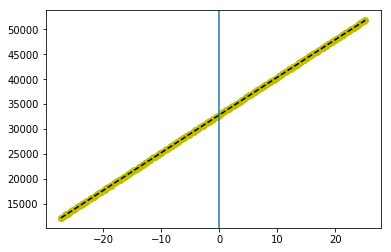

In [50]:
plt.plot(anaVoltages, digVoltages, 'yo', anaVoltages, [c3*av**3+c2*av**2+c1*av+c0 for av in anaVoltages], '--k')
plt.axvline(0)
# plt.axhline(0)

In [52]:
registry.cd(['', 'Servers', 'electronDAC Server', 'Calibrations', str(channelToCalib)], True)
registry.set('c0', fit[3])
registry.set('c1', fit[2])
registry.set('c2', fit[1])
registry.set('c3', fit[0])

# Rename calibration folder name from trap electrode number to DAC chip number

In [101]:
# #dacserver.set_individual_analog_voltages([(str(9).zfill(2), 2)]) 
# dacserver.set_individual_digital_voltages([(str(channelToCalib).zfill(2), 33532)])
# time.sleep(0.50)
# float(keithley.query('MEAS:VOLT:DC?'))
# float(keithley.query('MEAS:VOLT:DC?'))

In [10]:
channelToCalib = 'tr2'
for i in range(20):
    dacserver.set_individual_analog_voltages([(str(channelToCalib).zfill(2), 10)])
    time.sleep(5)
    print(round(float(keithley.query('MEAS:VOLT:DC?')),4))

10.0011
10.001


KeyboardInterrupt: 